Math087 - Mathematical Modeling
===============================
[Tufts University](http://www.tufts.edu) -- [Department of Math](http://math.tufts.edu)  
[Arkadz Kirshtein](https://math.tufts.edu/people/facultyKirshtein.htm) <arkadz.kirshtein@tufts.edu>   
*Fall 2023*

*Based on materials created by James Adler and George McNinch*

Course material (Class 1): Optimization
--------------------------------------

Some generalities
-----------------
Optimization is the most common application of mathematics. Here are some “real-world” examples:

- **Business optimization**. A business manager attempts to understand and control parameters in order to maximize profit and minimize costs.

- **Natural resource management**. Control harvest rates to maximize long-term yield, while conserving resources.

- **Environmental regulation**. Governments sets standards to minimize environmental costs, while maximizing production of goods.

- **IT management**. Computer system managers try to maximize throughput and minimize delays.

- **Pharmaceutical optimization**. Doctors and pharmacists regulate drugs to minimize harmful side effects and maximize healing.

In this first part of our modeling course, we are going to discuss some sorts of optimization problems and related matters:

- *single variable optimization* and *sensitivity analysis*

- *multivariable optimization*

- *multivariable optimization with constraints*

# Single Variable Optimization

In this first section of our modeling class, we are going to examine a few *single variable* optimization problems. In some sense, these amount of complicated versions of *word problems* that you might have met in Calculus I (differential calculus).

The procedure to carry out a calculus based solution can then be described roughly as follows: 

- find the function $f(x)$ that measures the quantity that you desire
  to optimize, and the relevant interval $[a,b]$ of values of
  independent variable $x$.
- find the critical points $c_1,c_2,\dots,c_N$ of $f$ in the interval $(a,b)$.
- if $f$ is a *nice enough* function, the maximum and minimum value of
  $f$ will be found in the list $f(a),f(c_1),\dots,f(c_N),f(b)$ --
  remember that you must check the endpoints $a,b$!  




## Example: Oil spill 

> An oil spill has contaminated 200 miles of Alaskan shoreline. The
> shipping company responsible for the accident has been given 14 days
> to clean up the shoreline, after which it will be required to pay a
> fine of \\$10,000 per day for each day in which any part of the
> shoreline remains uncleaned.

Let's assume that the fine depends on fractional days. For example,
if the work is completed in 15.5 days, we'll suppose that the company would pay a
fine of 

$$1.5 \cdot 10000 = 15000.$$

> Cleanup crews can be hired, and each crew cleans 5 miles of beach per week.
> 
> There is one local cleanup crew available at a cost of \\$500 per day. 
>
> Additional non-local crews can be hired. The hire of each non-local
> crew incurs an \\$18,000 one-time travel cost. These additional
> crews work for \\$800 per day for each crew (and each crew has the
> same cleanup rate of 5 miles of beach per week).

Relevant parameters:

* miles cleaned per crew per week = $5$, so
* $m$ = miles cleaned per crew per day = $5/7$
* $f$ = fine charged per day = \\$$10,000$
* $TC$ = travel costs per outside crew = \\$$18,000$


The main choice that the company must make is: "how many outside crews to hire?"

* $n$ = # of outside crews to hire

According to the background description, there are a number of quantities that depend on this choice:

* $t$ = # of days for complete cleanup
* $F$ = fine to be paid
* $C_{crew}$ = payments to cleanup crews
* $C_{tot}$ = total cleanup cost = $F + C_{crew}$

Let's give **mathematical expressions** for these quantities:

$t = 200\cdot \dfrac{1}{n+1} \cdot \dfrac{1}{m}$

(Indeed, $n+1$ crews working at a rate of $m$ miles per day
will clean 200 miles of beach in the indicated number of days)

$F= \begin{cases} 0 & \text{if $t<14$} \\ f\cdot(t-14) & \text{if $t \ge 14$} \end{cases}$

(Indeed, no fine if work is completed within two weeks; otherwise, the
fine is given by the indicated formula)

$\begin{array}{rl}
C_{crew} = &{500\cdot t + 800\cdot t\cdot n + TC\cdot n}\\
C_{tot} = &{F + C_{crew}}\end{array}$

Now let's give `python` code for computing these quantities.


Note that we use the parameter values as *default values* for some of the arguments
of the *crew_cost* and *cost* functions.

In [1]:
class OilSpillCleanup:
    def __init__(self,cleanup_rate=5.0/7,tc=18000,miles=200,fine_per_day=10000):
        self.miles = miles                
        self.cleanup_rate = cleanup_rate   
        self.tc = tc                      
        self.fine_per_day = fine_per_day
       
    def report_parameters(self):
        lines = [f"> miles to clean :   {self.miles}",
                 f"> cleanup_rate   :   {self.cleanup_rate:.2f} (miles/day)/crew",
                 f"> transport costs: $ {self.tc:,d} per external crew",
                 f"> fine per day   : $ {self.fine_per_day:,d} per day",]
        return "\n".join(lines) + "\n"
                
    def time(self,n): 
        # time to clean the shoreline if n external crews are hired
        return self.miles/((n+1)*self.cleanup_rate)

    def fine(self,t): 
        # The total fine imposed. Depends on:
        # t = # of days for complete cleanup 
        return 0 if (t<14) else self.fine_per_day*(t-14)

    def crew_costs(self,n):
        # cost in payments to crews. Depends on
        # n = number of non-local crews hired
        t=self.time(n) # time for cleanup
        return 500*t + 800*t*n + self.tc*n

    def cost(self,n):
        # total expenses incurred for hire of n external crews
        t=self.time(n)
        return self.fine(t) + self.crew_costs(n) 

### Let's first just make a table of results

In our table, the rows will contain the values of the various
quantities for possible values of $n$, the number of "outside"
cleanup crews hired.

For this, we are going to use python's [**Pandas**
module](https://pandas.pydata.org/docs/index.html).  We'll use the
"DataFrame" data structure (which is a bit like a python dictionary
for which the keys are the column headers and the values are the
column data).

In [2]:
import pandas as pd

## The following overrides the usual display formatting of floating point numbers. 
## It is just an aesthetic choice...

pd.set_option('display.float_format', lambda x: "{:,.2f}".format(x))

In [3]:
# define an instance of the OilSpillCleanup class, with the default arguments.
c = OilSpillCleanup()

# and define a function of two arguments:
# c, a class of type OilSpillCleanup, and
# crew_range, a list of integers, to be used as the "number of external crews hired"
#             crew_range defaults to the list [0,1,...,24]
#
def oil_spill_costs(c, crew_range=range(0,25)):
    return pd.DataFrame(
            {'#external crews'      : crew_range,
             'cost'   : map( lambda n: c.cost(n) , crew_range),
             'days'   : map( lambda n: c.time(n) , crew_range),
             'fine'   : map( lambda n: c.fine(c.time(n)) , crew_range)
            },
            index=crew_range)

In [4]:
oil_spill_costs(c)  ## Compute use the *default* parameter values.

,#external crews,cost,days,fine
0,0,"2,800,000.00",280.00,"2,660,000.00"
1,1,"1,460,000.00",140.00,"1,260,000.00"
2,2,"1,025,333.33",93.33,"793,333.33"
3,3,"817,000.00",70.00,"560,000.00"
4,4,"699,200.00",56.00,"420,000.00"
5,5,"626,666.67",46.67,"326,666.67"
6,6,"580,000.00",40.00,"260,000.00"
7,7,"549,500.00",35.00,"210,000.00"
8,8,"529,777.78",31.11,"171,111.11"
9,9,"517,600.00",28.00,"140,000.00"


We can of course just scan the columns with our eyes to see where the costs are minimized. But we can also use *pandas* API-functions.

In the terminology of *pandas*, we'll extract the *costs* column `df['cost']` of the "dataframe" `df` as a *series*, and then use the `idxmin` method to find the *index* `j` at which the costs are minimized.
Finally, the loc property of `df` allows to select the data `df.loc[j]` in the row with index label `j`.

In [5]:
def minimize_costs(c,crew_range=range(0,25)):
    ## make the data-frame 
    costs_df = oil_spill_costs(c,crew_range) 
    ## find the index of the data-frame entry with minimal costs
    min_index = costs_df['cost'].idxmin()
    ## return the corresponding data-frame entry  
    return costs_df.loc[min_index]    

def report_minimal_costs(c,crew_range=range(0,25)):
    r = minimize_costs(c,crew_range)
    return "\n".join([f"For n in {crew_range}, and with these parameters:",
                      "",
                      c.report_parameters(),
                      f"the total costs are minimized by hiring n = {r['#external crews']} external crews.",
                      "Here are the details:",
                      "",
                      str(r)]) + "\n"


In [6]:
## c is the class obtained above via OilSpillCleanup()
##
print(report_minimal_costs(c))

For n in range(0, 25), and with these parameters:

> miles to clean :   200
> cleanup_rate   :   0.71 (miles/day)/crew
> transport costs: $ 18,000 per external crew
> fine per day   : $ 10,000 per day

the total costs are minimized by hiring n = 11.0 external crews.
Here are the details:

#external crews        11.00
cost              508,333.33
days                   23.33
fine               93,333.33
Name: 11, dtype: float64



### <a id='minimal_cost_cell'> Minimal costs (for basic parameters)</a>

From the preceding calculation, it appears that the cost is minimized
by hiring $n=11$ outside crews. With that number of crews, cleanup
takes slightly more than 3 weeks with a total cost of \\$508K
(including a fine of \\$93K).

Below, we'll use some calculus to confirm this observation!!!

Before talking about the calculus, let's observe that it is easy to look for minimal costs with other parameters. With this code, we need to be careful that the range of crew sizes the code considers is large enough, though. 

Consider the following example:

In [7]:
## make a new instance of our OilSpillCleanup class, with some different parameters

c1 = OilSpillCleanup(miles=300,fine_per_day=20000,tc=15000,cleanup_rate=.5)

## and look for minimal costs, first with the default range of n's, and then with a slightly bigger range:

print(report_minimal_costs(c1))

For n in range(0, 25), and with these parameters:

> miles to clean :   300
> cleanup_rate   :   0.50 (miles/day)/crew
> transport costs: $ 15,000 per external crew
> fine per day   : $ 20,000 per day

the total costs are minimized by hiring n = 24.0 external crews.
Here are the details:

#external crews          24.00
cost              1,032,800.00
days                     24.00
fine                200,000.00
Name: 24, dtype: float64



In [8]:
print(report_minimal_costs(c1,crew_range=range(0,35)))
## Notice! We wouldn't have seen the minimum if we had used the default crew_range...

For n in range(0, 35), and with these parameters:

> miles to clean :   300
> cleanup_rate   :   0.50 (miles/day)/crew
> transport costs: $ 15,000 per external crew
> fine per day   : $ 20,000 per day

the total costs are minimized by hiring n = 27.0 external crews.
Here are the details:

#external crews          27.00
cost              1,027,142.86
days                     21.43
fine                148,571.43
Name: 27, dtype: float64



-----
## <a id="calculus_cell">Applying calculus to the problem</a>

We now return to consideration of the "default values" of the parameters.

Our computations so far *suggest* - but don't *confirm* - the optimal number of crews to hire to minimize costs. We are going to use calculus to confirm this number for our "default" parameter values $m = 5.0/7$, $TC=18000$, $f=10000$, for 200 miles of coast.




Recall the formulas:

$\begin{array}{rl}
t = &200\cdot \dfrac{1}{n+1} \cdot \dfrac{1}{5/7} = \dfrac{280}{n+1}\\
F= &\begin{cases}  0 &  \text{if $t<14$} \\ 10000\cdot(t-14) & \text{if $t \ge 14$} \end{cases} \\
C_{crew} = &500\cdot t + 800\cdot t\cdot n + 18000\cdot n\\
C_{tot} = &F + C_{crew}
\end{array}$


$C_{tot}$ is expressed here as a function of both $t$ and $n$. But of course, $t$ is determined by $n$.

We want to express $C_{tot}$ as a function only of $n$. The obstacle here is that the fine $F$ is not expressed directly as a function of $n$, and the best way to deal with this is to consider different cases.

We first ask the question: "how many crews would we need if we were to clean
everything up in exactly 14 days?"

For this we must solve the equation $t(n)=14$; i.e.: 
$$14 = \dfrac{280}{1+n}$$

Thus, $n+1=\dfrac{280}{14}$. We find that
$n+1 = 20$ so that $n=19$. In other words, if 19 external crews are hired, work is completed in two weeks.

Thus we see that for $n \ge 19$ we have $F = 0$ and $C_{tot} = C_{crew}$, while for $n < 19$
$$F(n) = 10000\cdot \left (\dfrac{280}{1+n} - 14\right)$$ 

The remaining expenses are the costs associated with hiring cleanup crews. They are
given by the function:

$$C_{crew}(n) = \dfrac{500 \cdot 280}{1+n}+\dfrac{800 \cdot 280}{1+n}⋅n+18000⋅n $$

And, the total cost function is given as a function of $n$ by:
$$C_{tot}(n) =  \left \{ \begin{matrix} F(n) + C_{crew}(n) & n < 19 \\ C_{crew}(n) & n \ge 19\end{matrix} \right .$$ 

We now pause to use `python` to draw some graphs.


Of course, in python we find these functions using methods of the class `c = OilSpillCleanup()` as follows:

* $F(n)   \leftrightarrow$  `c.fine(c.time(n))`
* $C_{crew}(n) \leftrightarrow $ `c.crew_cost(n)`
* $C_{tot}(n) \leftrightarrow $ `c.cost(n)`

Graphs
------

For a specified class `c` of `OilSpillCleanup`, we can use python's [matplotlib](https://matplotlib.org/) package to draw graphs of the functions
`c.cost(n)` and `c.fine(c.time(n))` viewed as functions of `n`.


In [9]:
c = OilSpillCleanup()   ### the class with the default values

import matplotlib.pyplot as plt
import numpy as np

def create_graph(c, crew_min=2, crew_max=30, mesh=200, vlines = []):
    x = np.linspace(crew_min,crew_max,mesh)
        
    fig, ax = plt.subplots(figsize=(12,6))  
    ax.plot(x,np.array([c.cost(n) for n in x]),label="C_tot(n)")
    ax.plot(x,np.array([c.fine(c.time(n))  for n in x]),label="Fine(n)")

    ax.set_xlabel("# crews")
    ax.set_ylabel("total cost in $")
    ax.legend()

    for t in vlines:
        ax.axvline(x=t, color="red", dashes=[1,4])

    ax.set_title("Cleanup costs")
    return fig

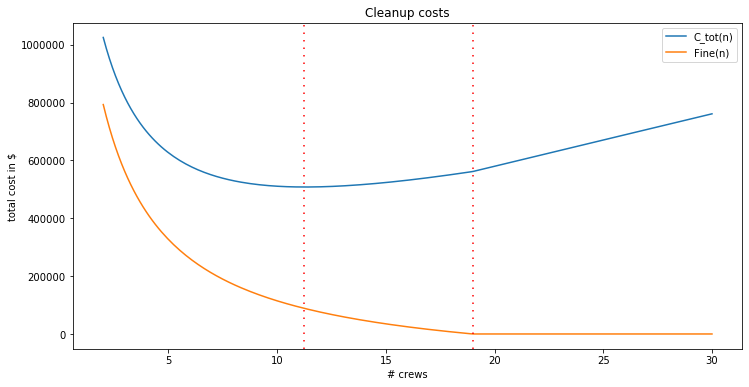

In [10]:
gg=create_graph(c,vlines=[11.23,19])

## the return value of create_graph 
## in a notebook, you'll just see the graph output.
## if not in a notebook, you should now call gg.show() in order to *see* the graph...

The interval $(19,\infty)$
--------------------------

Our computations strongly *suggest* that the costs are not minimized by taking $n$ in the interval $(19,\infty)$. Let's start our analysis by confirming this fact so that we can then focus on the cost function for $0 \le n \le 19$.

For $n \ge 19$, recall that
$$C_{tot}(n) = C_{crew}(n) = \dfrac{a}{n+1} + \dfrac{b\cdot n}{n+1} + cn$$
for constants $a,b,c$ given by $a = 500\cdot 280$, $b = 800 \cdot 280$ and $c = 18000$.

Differentiating in $n$, find that
$$(\clubsuit) \quad \dfrac{dC_{tot}}{dn} = c + \dfrac{b}{(n+1)^2} - \dfrac{a}{(n+1)^2}$$
since $\dfrac{d}{dn}\left[\dfrac{n}{n+1} \right] = \dfrac{1}{(1+n)^2} $.

For $n \ge 19$ notice that:
$$\dfrac{a}{(n+1)^2} \le \dfrac{a}{20^2} = 350.$$
Since $b$ is non-negative, we see:

$$c + \dfrac{b}{n+1} - \dfrac{a}{(n+1)^2} \ge c - 350 >0.$$

This confirms - as the above graph suggests -- that $C_{tot}$ is increasing for $n \ge 19$. Thus for $n$ in $[19,\infty)$ the minimal costs are located at the endpoint.

So to find the minimum value of the cost function $C_{\text{tot}}$ it is enough to find the minimum value for $n$ in the interval $[0,19]$.



The interval $[0,19]$
----------------------

For $0 \le n \le 19$, the total cost function now has the form

$$C_{tot}(n) = \dfrac{a_1}{n+1} + \dfrac{b \cdot n}{n+1} + cn + d$$

where $b$ and $c$ are as before but now $a_1 = (500 + 10000)\cdot 280 = 10500 \cdot 280$,
and where the constant $d$ is given by $d=-14\cdot 10000$.

The derivative $\dfrac{dC_{tot}}{dn}$ is still given by $(\clubsuit)$ with $a$ replaced by $a_1$.

To find critical points on the interval $(0,19)$, we solve the equation $\dfrac{dC_{tot}}{dn} = 0$ for $n$. Clearing denominators, we find that this amounts to solving the equation:
$$0 = -a_1 + b + c(n+1)^2$$
or
$$(n+1)^2 = \dfrac{a_1 - b}{c}$$

Since $n \ge 0$ is required by the problem, the solution is
$$n= -1+\sqrt{\dfrac{a_1 - b}{c}}$$


Let's compute this value:

In [11]:
a_1 = 10500*280
b=800*280
c=18000
-1 + np.sqrt((a_1 - b)/c)

11.283683848458853

Thus $C_{tot}$ has a critical point at a value slightly larger than $n=11$.

Note that 
$$\dfrac{d^2 C_{tot}}{dn^2} = \dfrac{d}{dn}\left[\dfrac{b-a_1}{(n+1)^2}\right]
= \dfrac{-2(b-a_1)}{(n+1)^3}$$

Since $b-a_1<0$, we find that $\dfrac{d^2 C_{tot}}{dn}$ is positive for $n \ge 0$. Thus, the graph is concave up and the indicated critical point is therefore a local minimum. 

The computations we already made using ``python`` then confirm that $n=11$ minimizes the cost function (without this numerical evidence, the minimum might have occurred at $n=12$, or at 
one of the endpoints $n=0$ or $n=19$).

-------

Sensitivity analysis
====================

We are interested in describing the extent to which the solution to an optimization problem
is sensitive to the parameters.

In the case of this oil-spill problem, parameters include:
- the length of beach that must be cleaned
- the rate of beach cleaning that a crew can achieve (miles/week)
- the travel costs per external crew
- the daily fine imposed 

We want a way of measuring how "sensitive" our solution was to a given parameter.

For instance, let’s assume that the amount of miles cleaned per week, $m$, were not known exactly. Let’s look at the cost function again, but regard $m$ in as an unknown parameter.


We consider the cost function for $n$ in the range in which the fine applies (how reasonable is that assumption?!)

As before, this function and its derivative have the form:
$$C_{tot}(n) = \dfrac{a}{n+1} + \dfrac{b \cdot n}{n+1} + cn + d$$
and
$$\dfrac{dC_{tot}}{dn} = c + \dfrac{b}{(n+1)^2} - \dfrac{a}{(n+1)^2}$$
Now, the coefficients $a,b,c,d$ depend on $m$.

More precisely, going back to the original formulation one seees that

- $a = \dfrac{10500 \cdot 200}{m}$

- $b = \dfrac{800 \cdot 200}{m}$

- $c = 18000$

- $d = 14 \cdot 10000$

Our earlier calculations show that $C_{tot}$ has exactly one critical point in the interval $n \ge 0$; in this situtation it is
$$n= -1+\sqrt{\dfrac{a - b}{c}} = -1 + \sqrt{\dfrac{(10500-800)\cdot 200}{18000 \cdot m}} \approx -1 + \sqrt{\dfrac{107.7}{m}}$$

Recall that the original value of $m$ was $5/7 \approx 0.71429$ miles per day.

If instead $m = .75$, we find the critical point at
$$n \approx -1 + \sqrt{\dfrac{107.7}{.75}} \approx 10.98$$

If $m=.65$, we find the critical point at
$$n \approx -1 + \sqrt{\dfrac{107.7}{.65}} \approx 11.87$$

There is certainly *some* dependence on $m$, but it doesn't seem *too* sensitive.

If a quantity $y = y(x)$ depends on a quantity $x$, the sensitivity of $y$ to $x$ is defined to be
the relative change in $y$ brought about by a relative change in $x$:
$$\dfrac{\dfrac{\Delta y}{y}}{\dfrac{\Delta x}{x}}=
\dfrac {\dfrac{y(x+\Delta x) - y(x)}{y(x)}}{\dfrac{\Delta x}{x}}=
\dfrac{y(x+\Delta x) - y(x)}{\Delta x} \cdot \dfrac{x}{y(x)}$$

Taking the limit as $\Delta x \to 0$, this expression becomes
$$S(y,x) = \dfrac{dy}{dx}\cdot \dfrac{x}{y}.$$

In our problem, we consider the dependence of the critical point $n = n(m)$ on the quantity $m$.
We have seen that
$$n(m)\approx -1 + \sqrt{\dfrac{107.7}{m}} = -1 + \sqrt{107.7}\cdot m^{-0.5}$$

So the sensitivity $S(n,m)$ is given by
$$S(n,m) = \dfrac{dn}{dm} \cdot \dfrac{m}{n(m)} =  107.7 \cdot (-0.5) \cdot m^{-1.5} \cdot \dfrac{m}{-1 + 107.7 \cdot m^{-0.5}}
= \dfrac{53.8 \cdot m^{0.5}}{1 - 107.7 \cdot m^{-0.5}}
= \dfrac{53.8 \cdot m}{\sqrt{m} - 107.7}
$$

So e.g. when $m = 5/7 = 0.714$, we find that
$$S(n,0.714) \approx -0.35949$$

Thus a 1% change in the miles of beach cleaned per day by a crew results in  roughly a third of a % change in the optimal value of $n$.

In contrast, if we did the same calculation with the fine amount, $f$ , we’d obtain $S(n, f) \approx 0.561$,
for $f = 10,000$.
Of course, this doesn’t sound very different, but note that while a 1% error in $m$ is reasonable, we probably expect
much larger changes in $f$ (e.g. one can imagine regulators doubling the fine!).
A 100% change in $f$ results in about a 56% change in $n$,
so our strategy is not robust to "expected" changes in $f$.

Finally, you may have been disappointed to have to do calculations with paper-and-pencil. 

### Avoiding the paper-and-pencil work with symbolic calculations

Computers can *approximate* derivatives in various ways, and this can be useful. But sometimes computers can even do symbolic calculations. The effectiveness of such calculations in general is probably somewhat limited, but e.g. if you know anything about computer algebra systems (Mathematica, Matlab, ...) you know that they can calculate (some) derivatives. 

Can we do the same in ``python``?? 

Of course!! I'm just going to give a sketch here.

For more details about symbolic calculations in python consult [symbolic mathematics package](https://www.sympy.org/en/index.html).

Recall the `python` expressions for the main funtion of interest:

* $C_{tot}(n) \leftrightarrow $ `c.cost(n)`



We will make a "symbolic variable" we'll call `y`.

We would like to make a symbolic version the `python` function `c.cost(n)` by valuation at  `n=y`.

Unfortunately, our definition of `c.cost(n)` involved a test of inequality (to decide whether the fine calculation applied). But it is not "legal" to test inequalities with the symbol `y`. (More precisely, such tests can't be sensibly interpreted).

For small enough $n$, `c.cost(n)` is equal to
`c.crew_costs(n) + c.fine_per_day * (c.time(n)-14)`. And this latter expression *can* be evaluated at the symbolic variable `y`.

And *sympy* permits us to symbolically differentiate the resulting expression:

We carry this out in the next cell:

In [12]:
import sympy as sp
c = OilSpillCleanup()

y = sp.Symbol('y')    # symbolic variable

def lcost(n):
    return c.crew_costs(n) + c.fine_per_day * (c.time(n) - 14)

lcost_symb = lcost(y)

d_lcost_symb = sp.diff(lcost_symb,y)  # first derivative, for n<19
dd_lcost_symb = sp.diff(d_lcost_symb,y) # second derivative, for n<19

print(f"C(y) = {lcost_symb}\n\n")
print(f"C'(y) = {d_lcost_symb}\n\n")
print(f"C''(y) = {dd_lcost_symb}\n\n")

C(y) = 18000*y + 160000*y/(0.714285714285714*y + 0.714285714285714) - 140000 + 2100000/(0.714285714285714*y + 0.714285714285714)


C'(y) = -224000.0*y/(y + 1)**2 + 18000 - 2940000.0/(y + 1)**2 + 160000/(0.714285714285714*y + 0.714285714285714)


C''(y) = 448000.0*y/(y + 1)**3 - 448000.0/(y + 1)**2 + 5880000.0/(y + 1)**3




Now e.g. `sympy` solvers are able to find the critical point for the symbolic derivative `d_lcost_symb`, as follows:

In [13]:
sp.solve(d_lcost_symb,y)

[-13.2836838484589, 11.2836838484589]

This finds our postive critical point of 11.28. 

This is convenient, but to solve the problem we still require analysis e.g. about the interval $19 < n$ (which isn't modelled by our symbolic function `lcost_symb`) and
it requires us to study the critical point (apply second derivative test etc.) So there remains work to be done...
----

# Follow-up: Some general ideas behind modeling

1. Ask the question:
    * Here the question should be phrased correctly in mathematical terms; this will help make clear what must be found.
    * Make a list of all the variables and constants; include units as appropriate.
    * State all assumptions about these variables and constants; include equations and inequalities.
    * Check units to make sure things make sense.
    * State your objective in mathematical terms (i.e., "minimization problem" in the example above).
    * It may even be useful to make an educated guess at this point on what the answer should be. 
<!-- -->
2. Select the modeling approach.
    - Choose a general solution procedure to solve the mathematical problem (in our case first and second derivative tests).
    - This might be the most difficult part and to a large extent depends on just good experience. That’s our goal...to get some experience.
<!-- -->
3. Formulate the model.
    - Restate the question in terms of your model (in our example, what function are we taking the derivative of?).
    - You may need to relabel or redefine things to make it work. This is where the mathematical model and real physical model may start to differ...
<!-- -->
4. Solve the model.
    - Apply Step 2 to Step 3.
    - Use any useful technologies, such as computation if necessary, but consider the errors that they may introduce.
<!-- -->
5. Answer the question.
    - Rephrase the result of Step 4 in non-technical terms.
    - Goal is now to make your answer understandable to the person that posed it, keeping in mind that person may not be a mathematician.
    - Think about what the errors might be, or how realistic the answer actually is.
    - How did it compare to what expectations?

Of course this is very general and may be problem dependent, but it at least describes our goals in modeling.